see https://github.com/bearpelican/musicautobot/tree/master/notebooks/music_transformer for code reference

The pretrain-generation notebook provides a demonstration of how to generate MIDI files using a pre-trained model provided by musicautobot library. The output of the notebook is a MIDI file that can be played back using an external software synthesizer or converted to an audio file using tools like Music21 or FluidSynth.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')
print(os)

<module 'os' from '/Users/caslabs/opt/anaconda3/envs/musicautobot/lib/python3.10/os.py'>


In [3]:
from utils.musicautobot.numpy_encode import *
from utils.musicautobot.utils.file_processing import process_all, process_file
from utils.musicautobot.config import *
from utils.musicautobot.music_transformer import *

2023-04-20 03:05:04.652631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate Music with Pretrained Model

### Load Pretrained

In [4]:
# Location of your midi files
midi_path =  Path('data/musicautobot-midi/examples')

data_path = Path('data/musicautobot-midi/examples')

In [5]:
# Data
data = MusicDataBunch.empty(data_path)
vocab = data.vocab

# For Saved Data:
# data = load_data(data_path, 'musicitem_data_save.pkl')

# Pretrained Model
Download pretrained model if you haven't already
'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'

Put the pretrained model in the /data/numpy/models folder

In [6]:
# Learner
learn = music_model_learner(data, pretrained_path="./data/models/MusicTransformerKeyC.pth")

## Prediction

#### Choose existing midi file as a starting point

In [7]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('data/musicautobot-midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/musicautobot-midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/musicautobot-midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('data/musicautobot-midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid')]

In [8]:
for i in range(0, len(midi_files)): print(midi_files[i])
idx = 17
f = midi_files[idx]; f

data/musicautobot-midi/examples/Levels - Avicii - Verse.mid
data/musicautobot-midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid
data/musicautobot-midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid
data/musicautobot-midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid
data/musicautobot-midi/examples/In The Hall Of The Mountain King - Edvard Grieg - Intro.mid
data/musicautobot-midi/examples/Colors Of The Wind - Disney - Chorus.mid
data/musicautobot-midi/examples/I Want You Back - Jackson 5 - Intro.mid
data/musicautobot-midi/examples/Fuer Elise - Ludwig Van Beethoven - Verse.mid
data/musicautobot-midi/examples/A Thousand Miles - Vanessa Carlton - Verse-And-Pre-Chorus.mid
data/musicautobot-midi/examples/The Four Seasons Concerto No 4 Winter - Antonio Vivaldi - Instrumental.mid
data/musicautobot-midi/examples/La Bamba - Ritchie Valen - Chorus.mid
data/musicautobot-midi/examples/Just Give Me A Reason - Pink - Chorus.mid
data/musicautobot-midi

PosixPath('data/musicautobot-midi/examples/3450entrancegodsvalhalarstevenritchie.mid')

#### NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [9]:
cutoff_beat = 10

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

/Users/caslabs/Documents/labs/APPLYAI/music-generation/utils/musicautobot/numpy_encode.py:53: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)


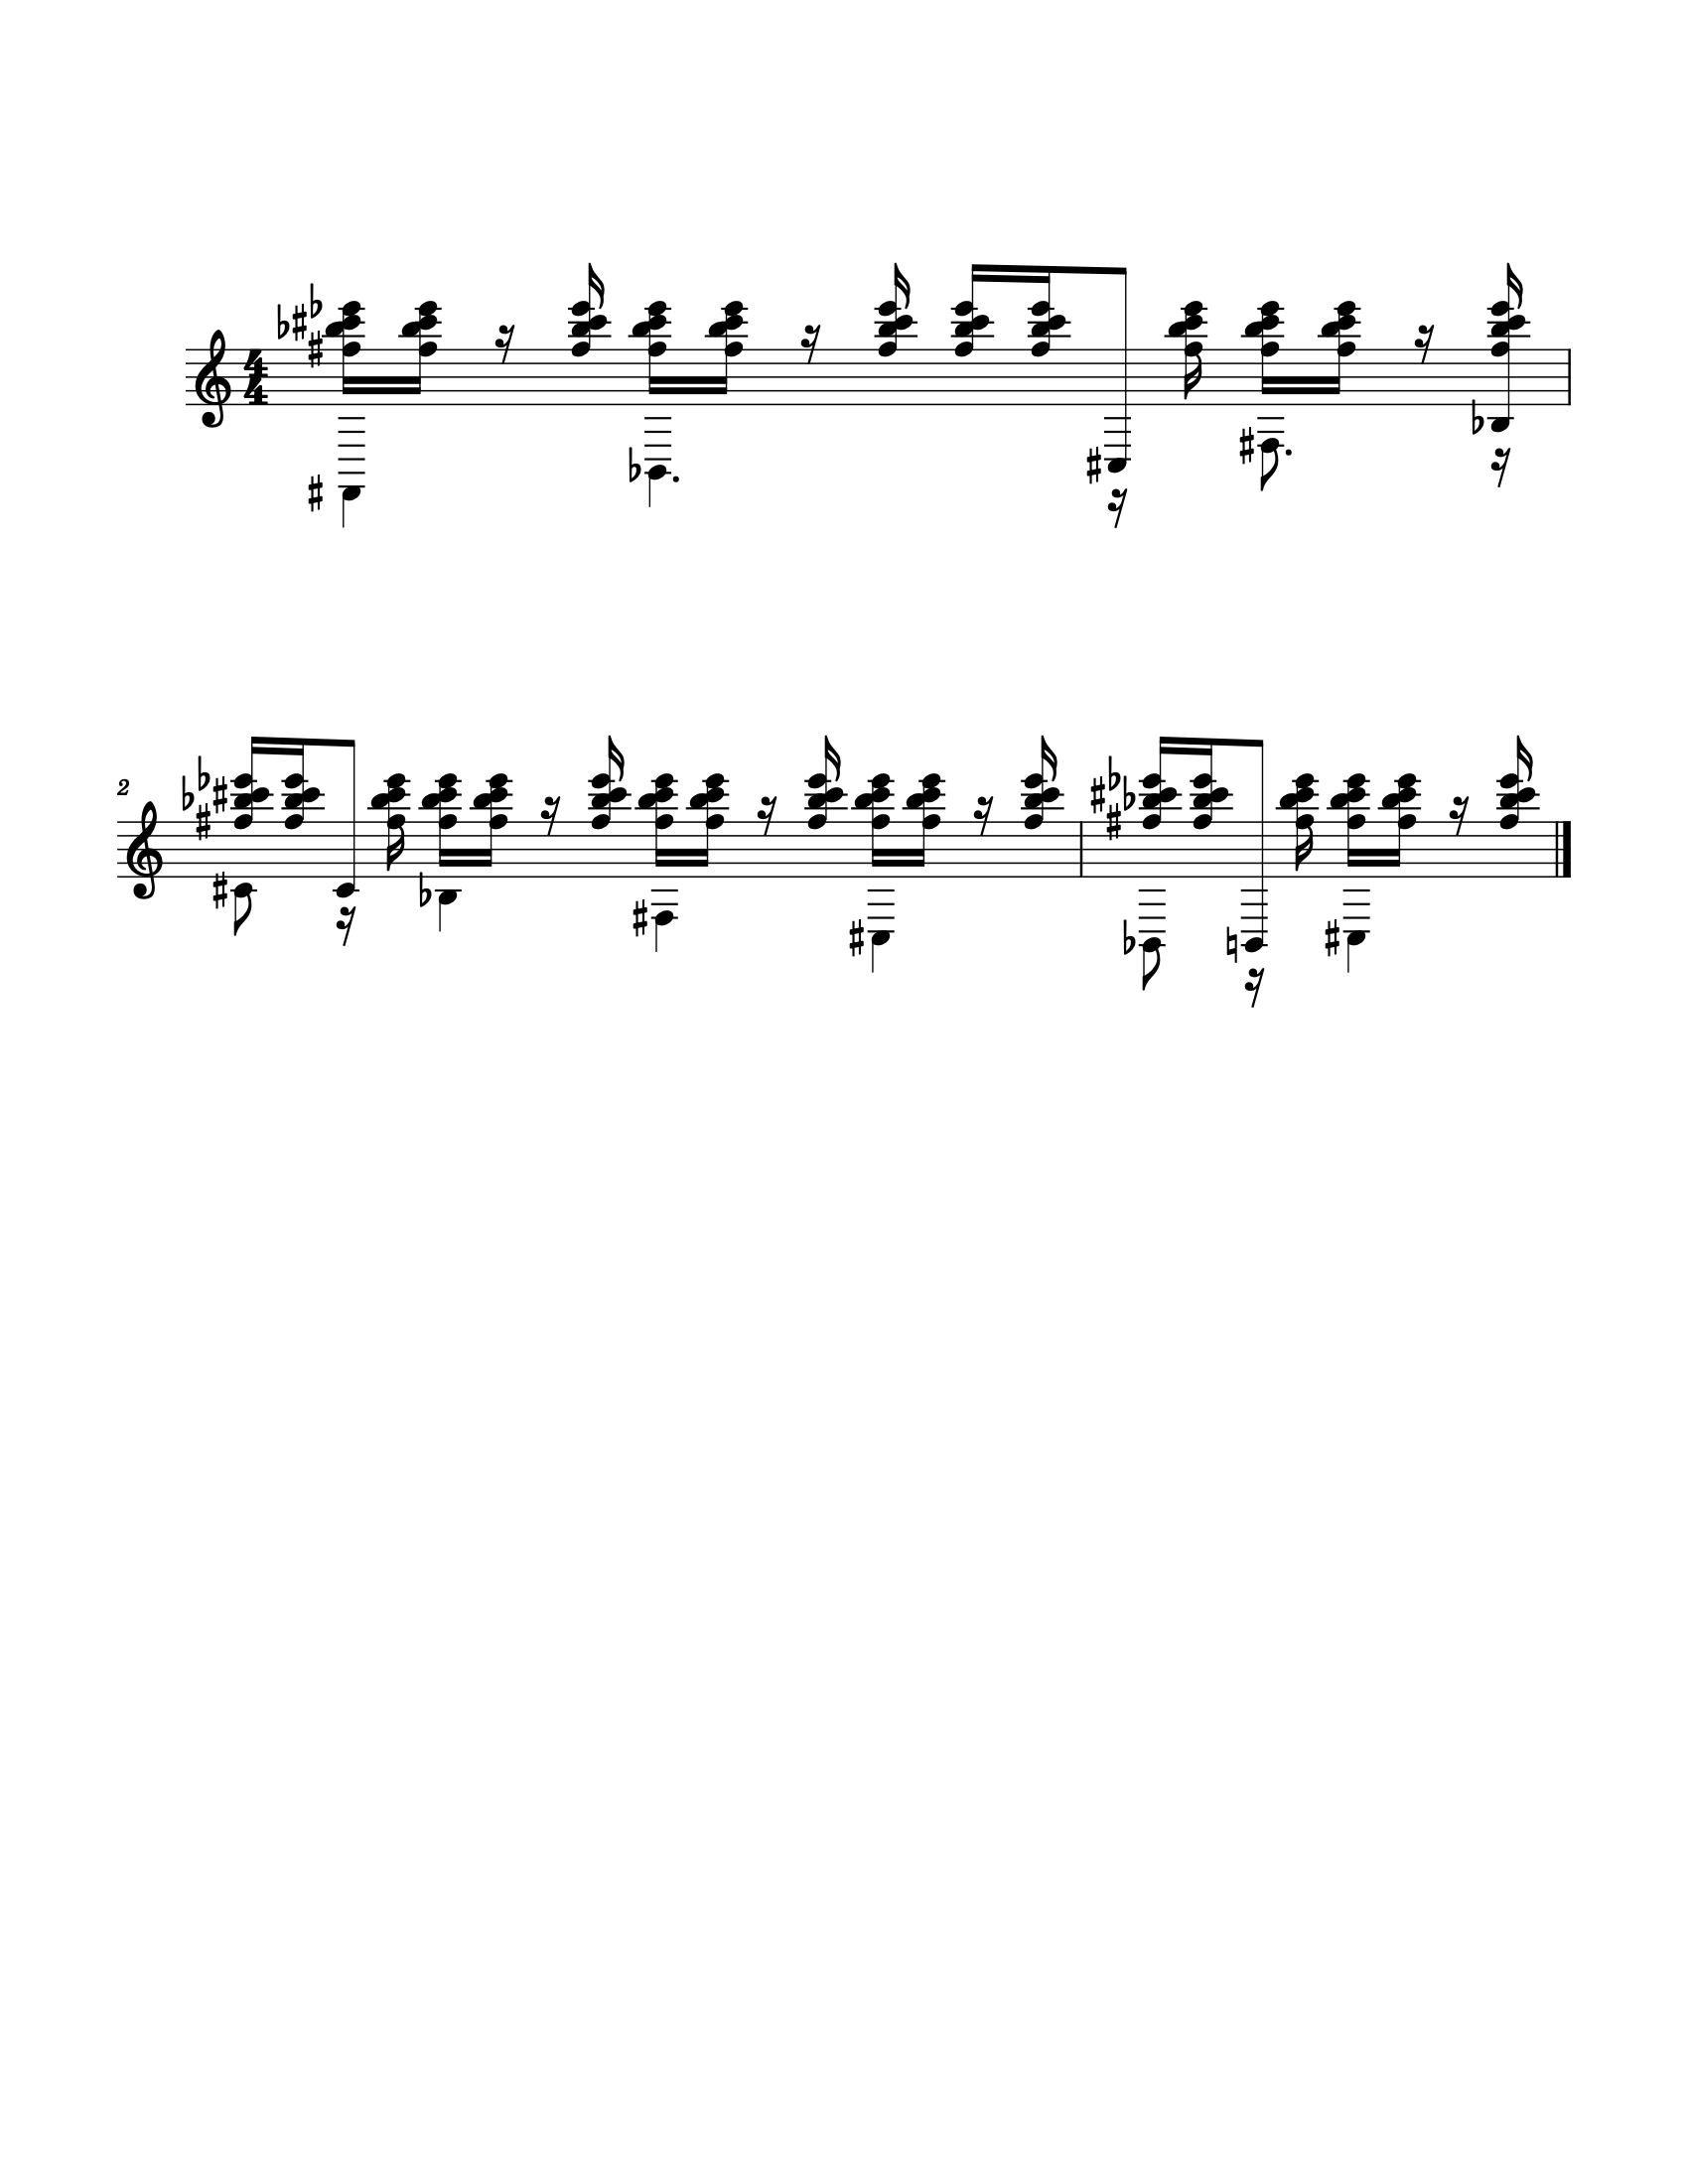

In [10]:
seed_item.show()

In [11]:
seed_item.play()
seed_item.download(filename='data/input/example_input_1.mid', ext='mid')

'data/input/example_input_1.mid'

#### Use seed to predict next sequence

In [12]:
pred, full = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

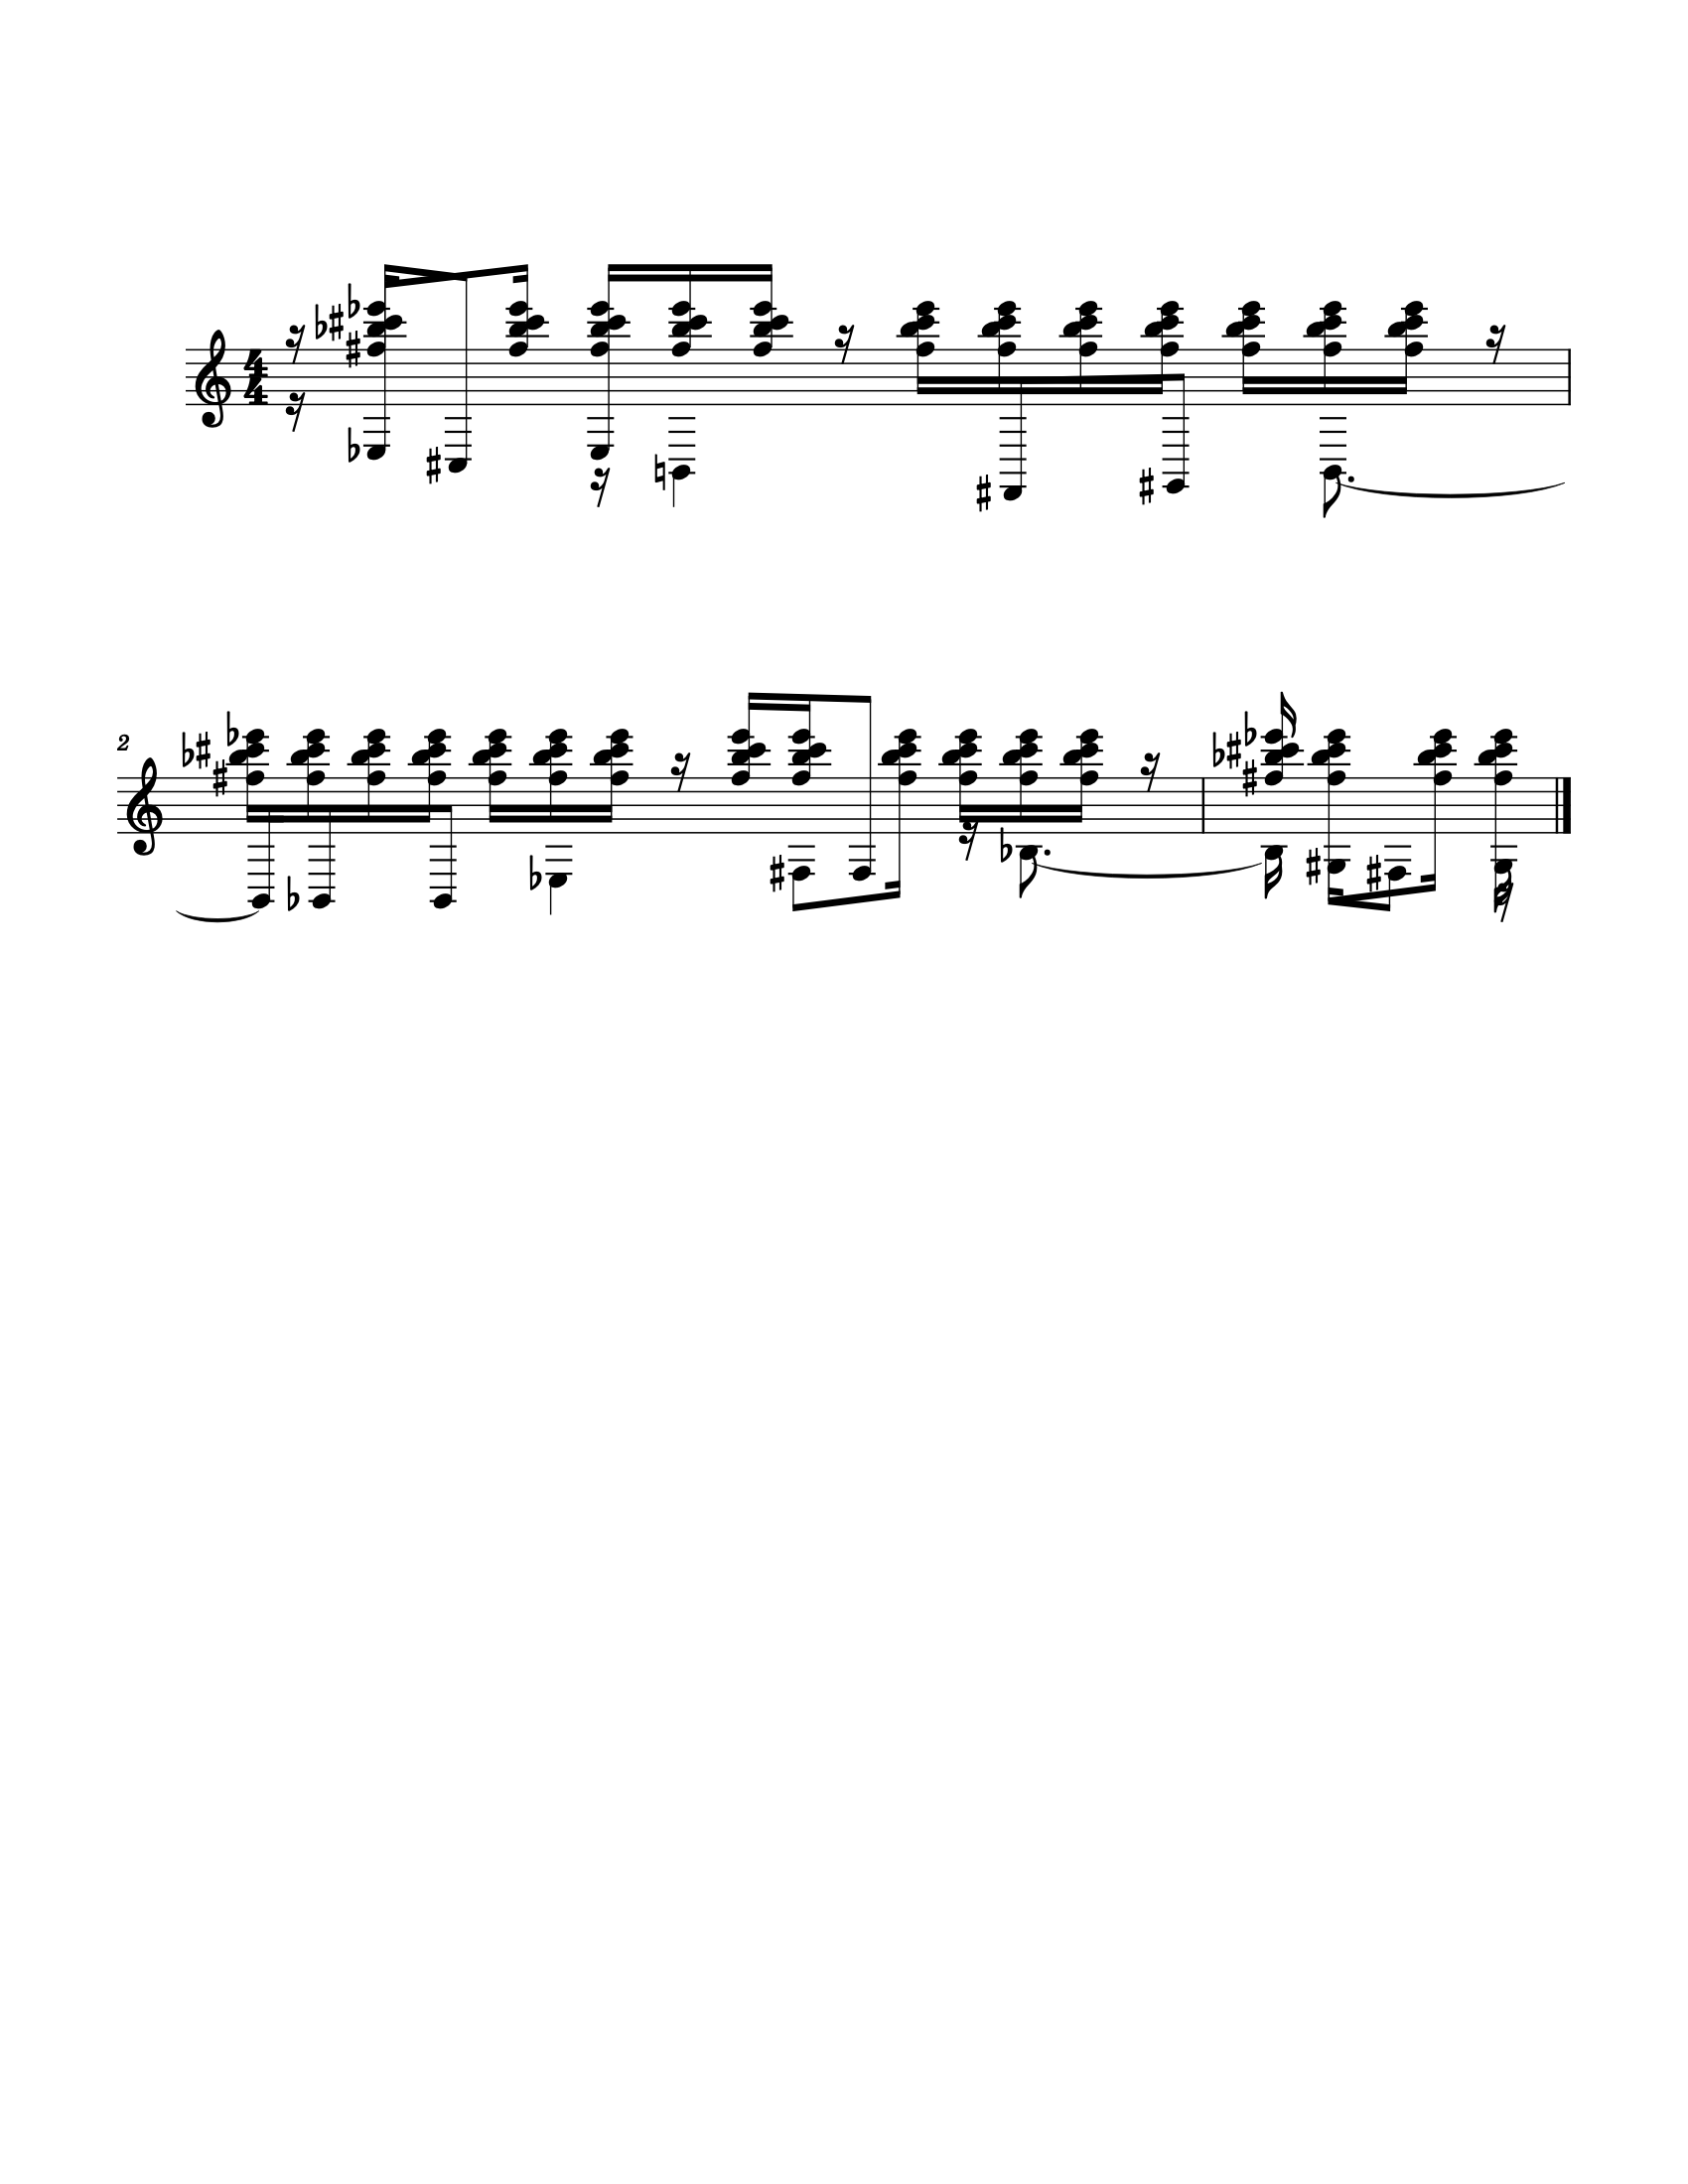

In [13]:
pred.show()

In [14]:
pred.play()

In [15]:
# write the stream to a MIDI file
pred.download(filename='data/output/generated_output_1.mid', ext='mid')

'data/output/generated_output_1.mid'

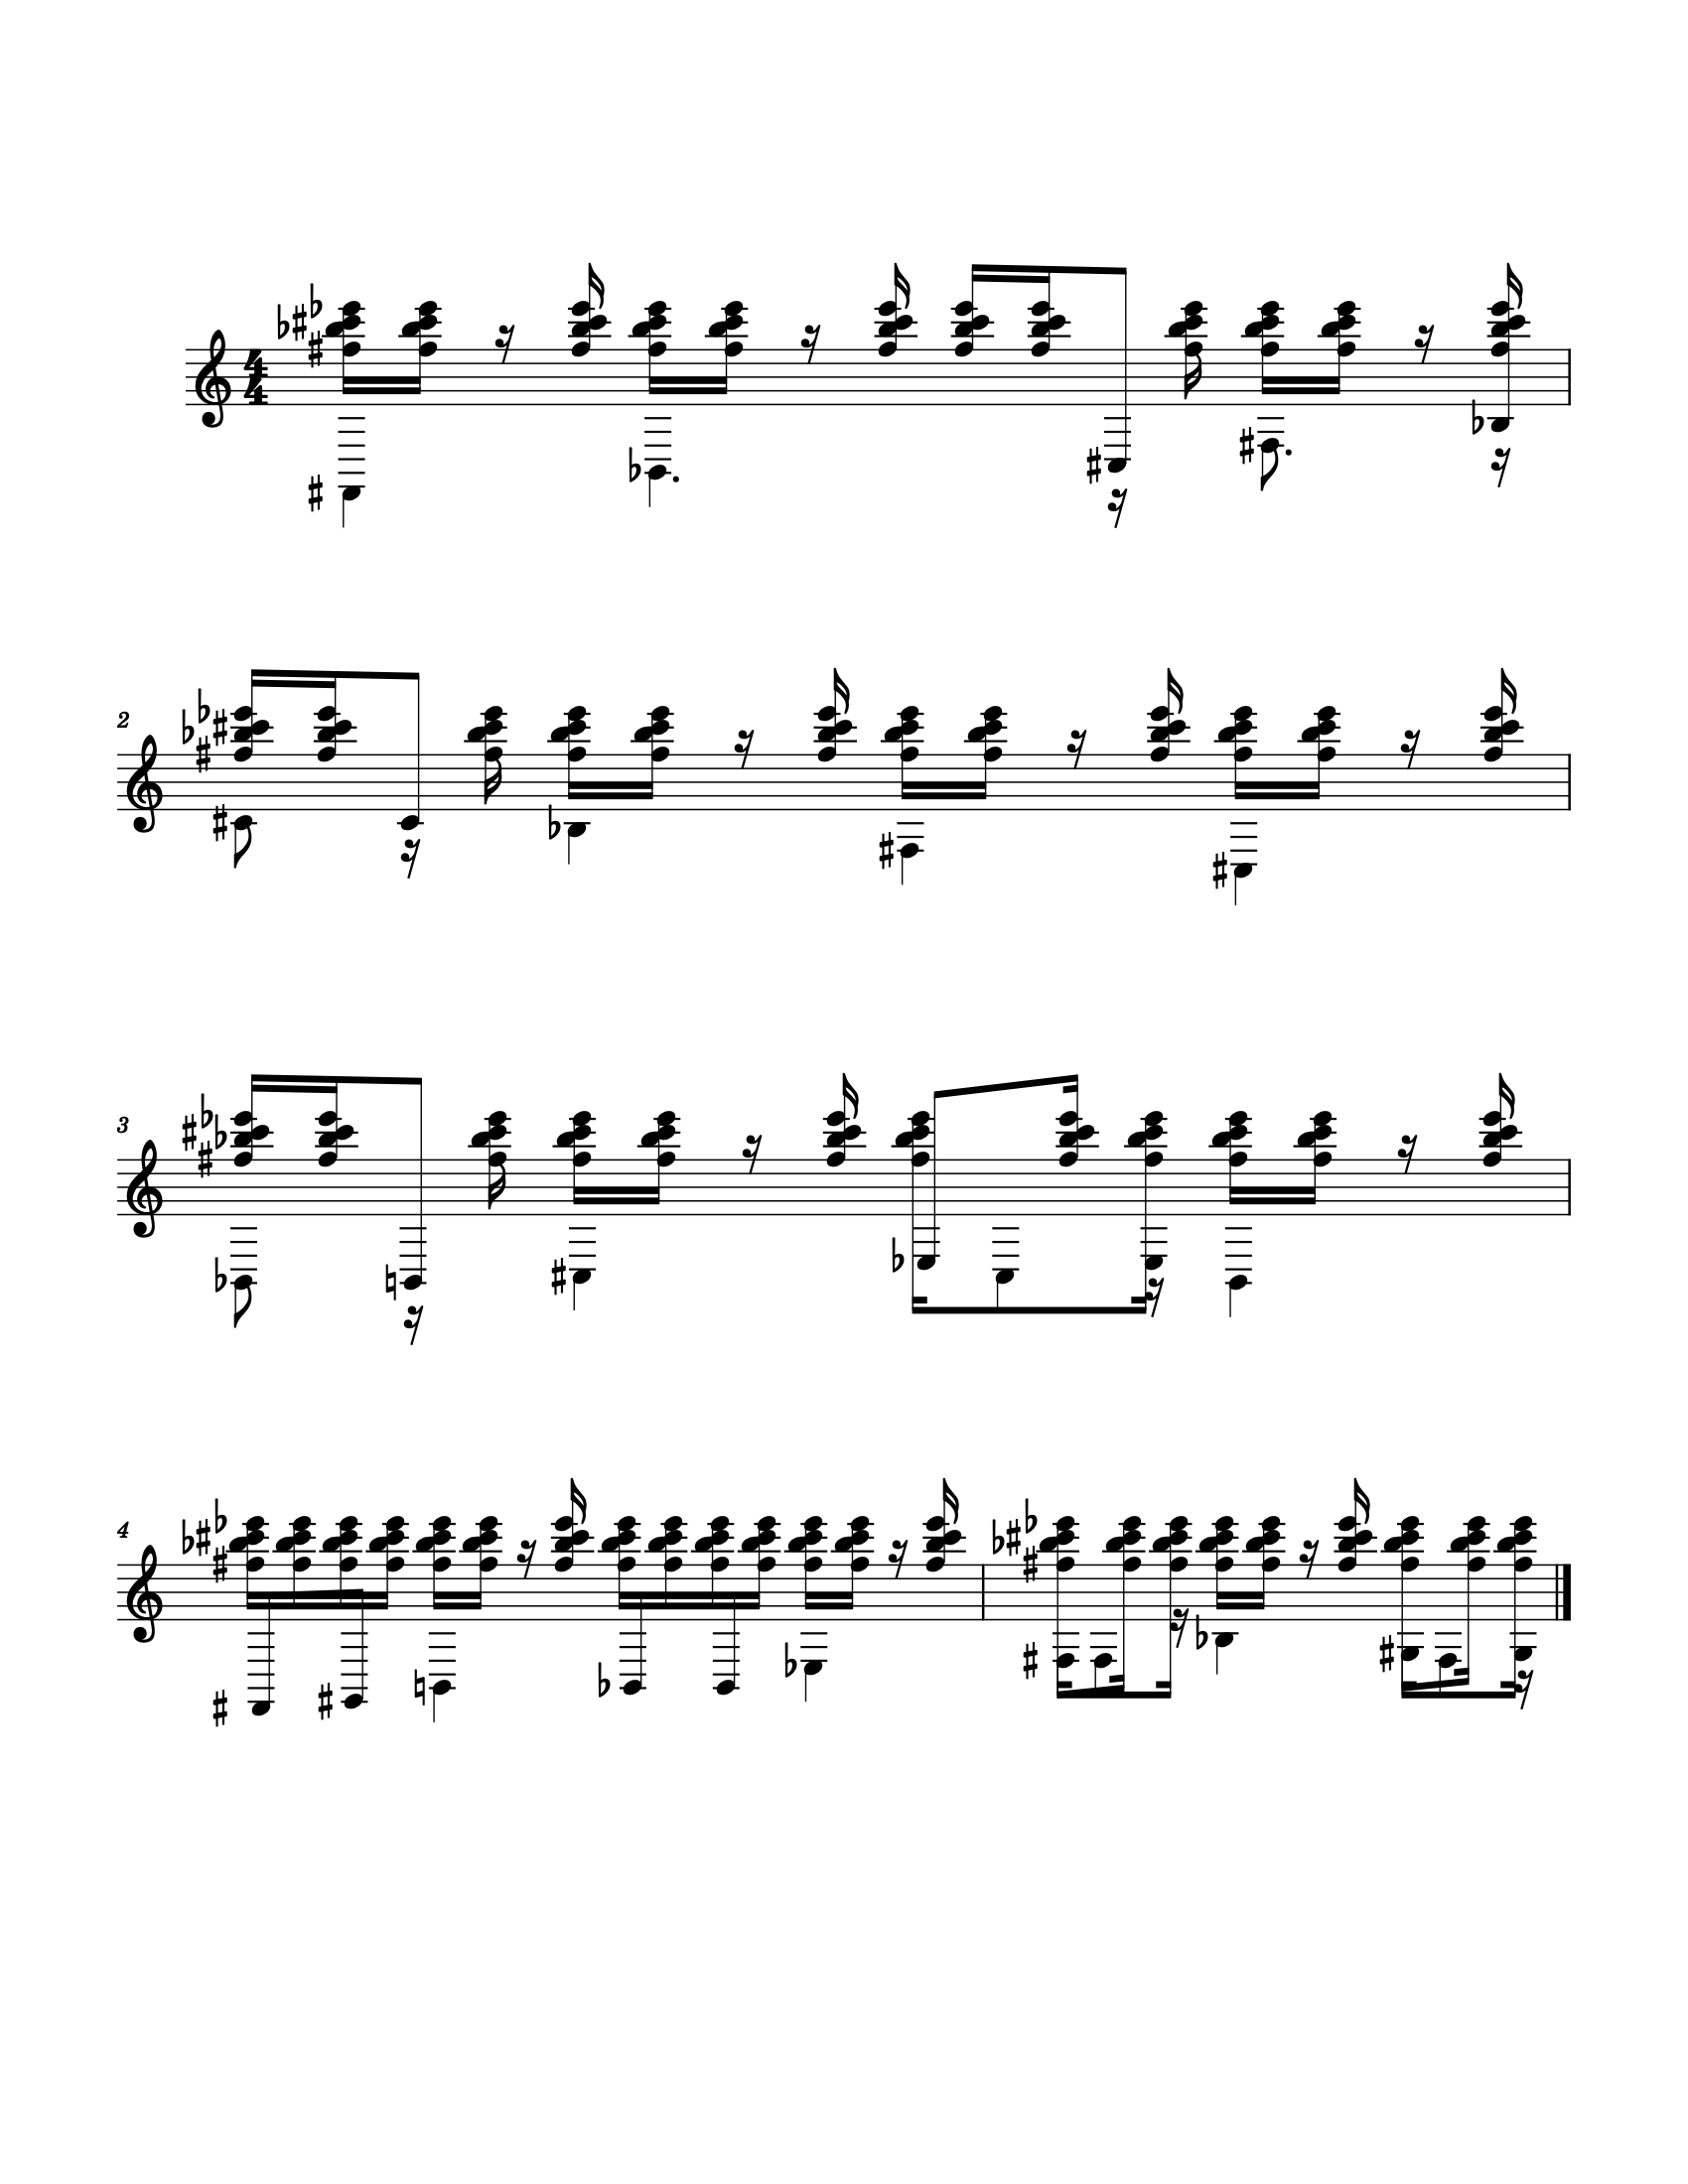

In [16]:
full_song = seed_item.append(pred); full_song.show()

In [17]:
# write the stream to a MIDI file
full_song.download(filename='data/output/generated_output_TEST.mid', ext='mid')

'data/output/generated_output_TEST.mid'

In [18]:
full_song.play()

#### Add More Randomness to prediction

In [19]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

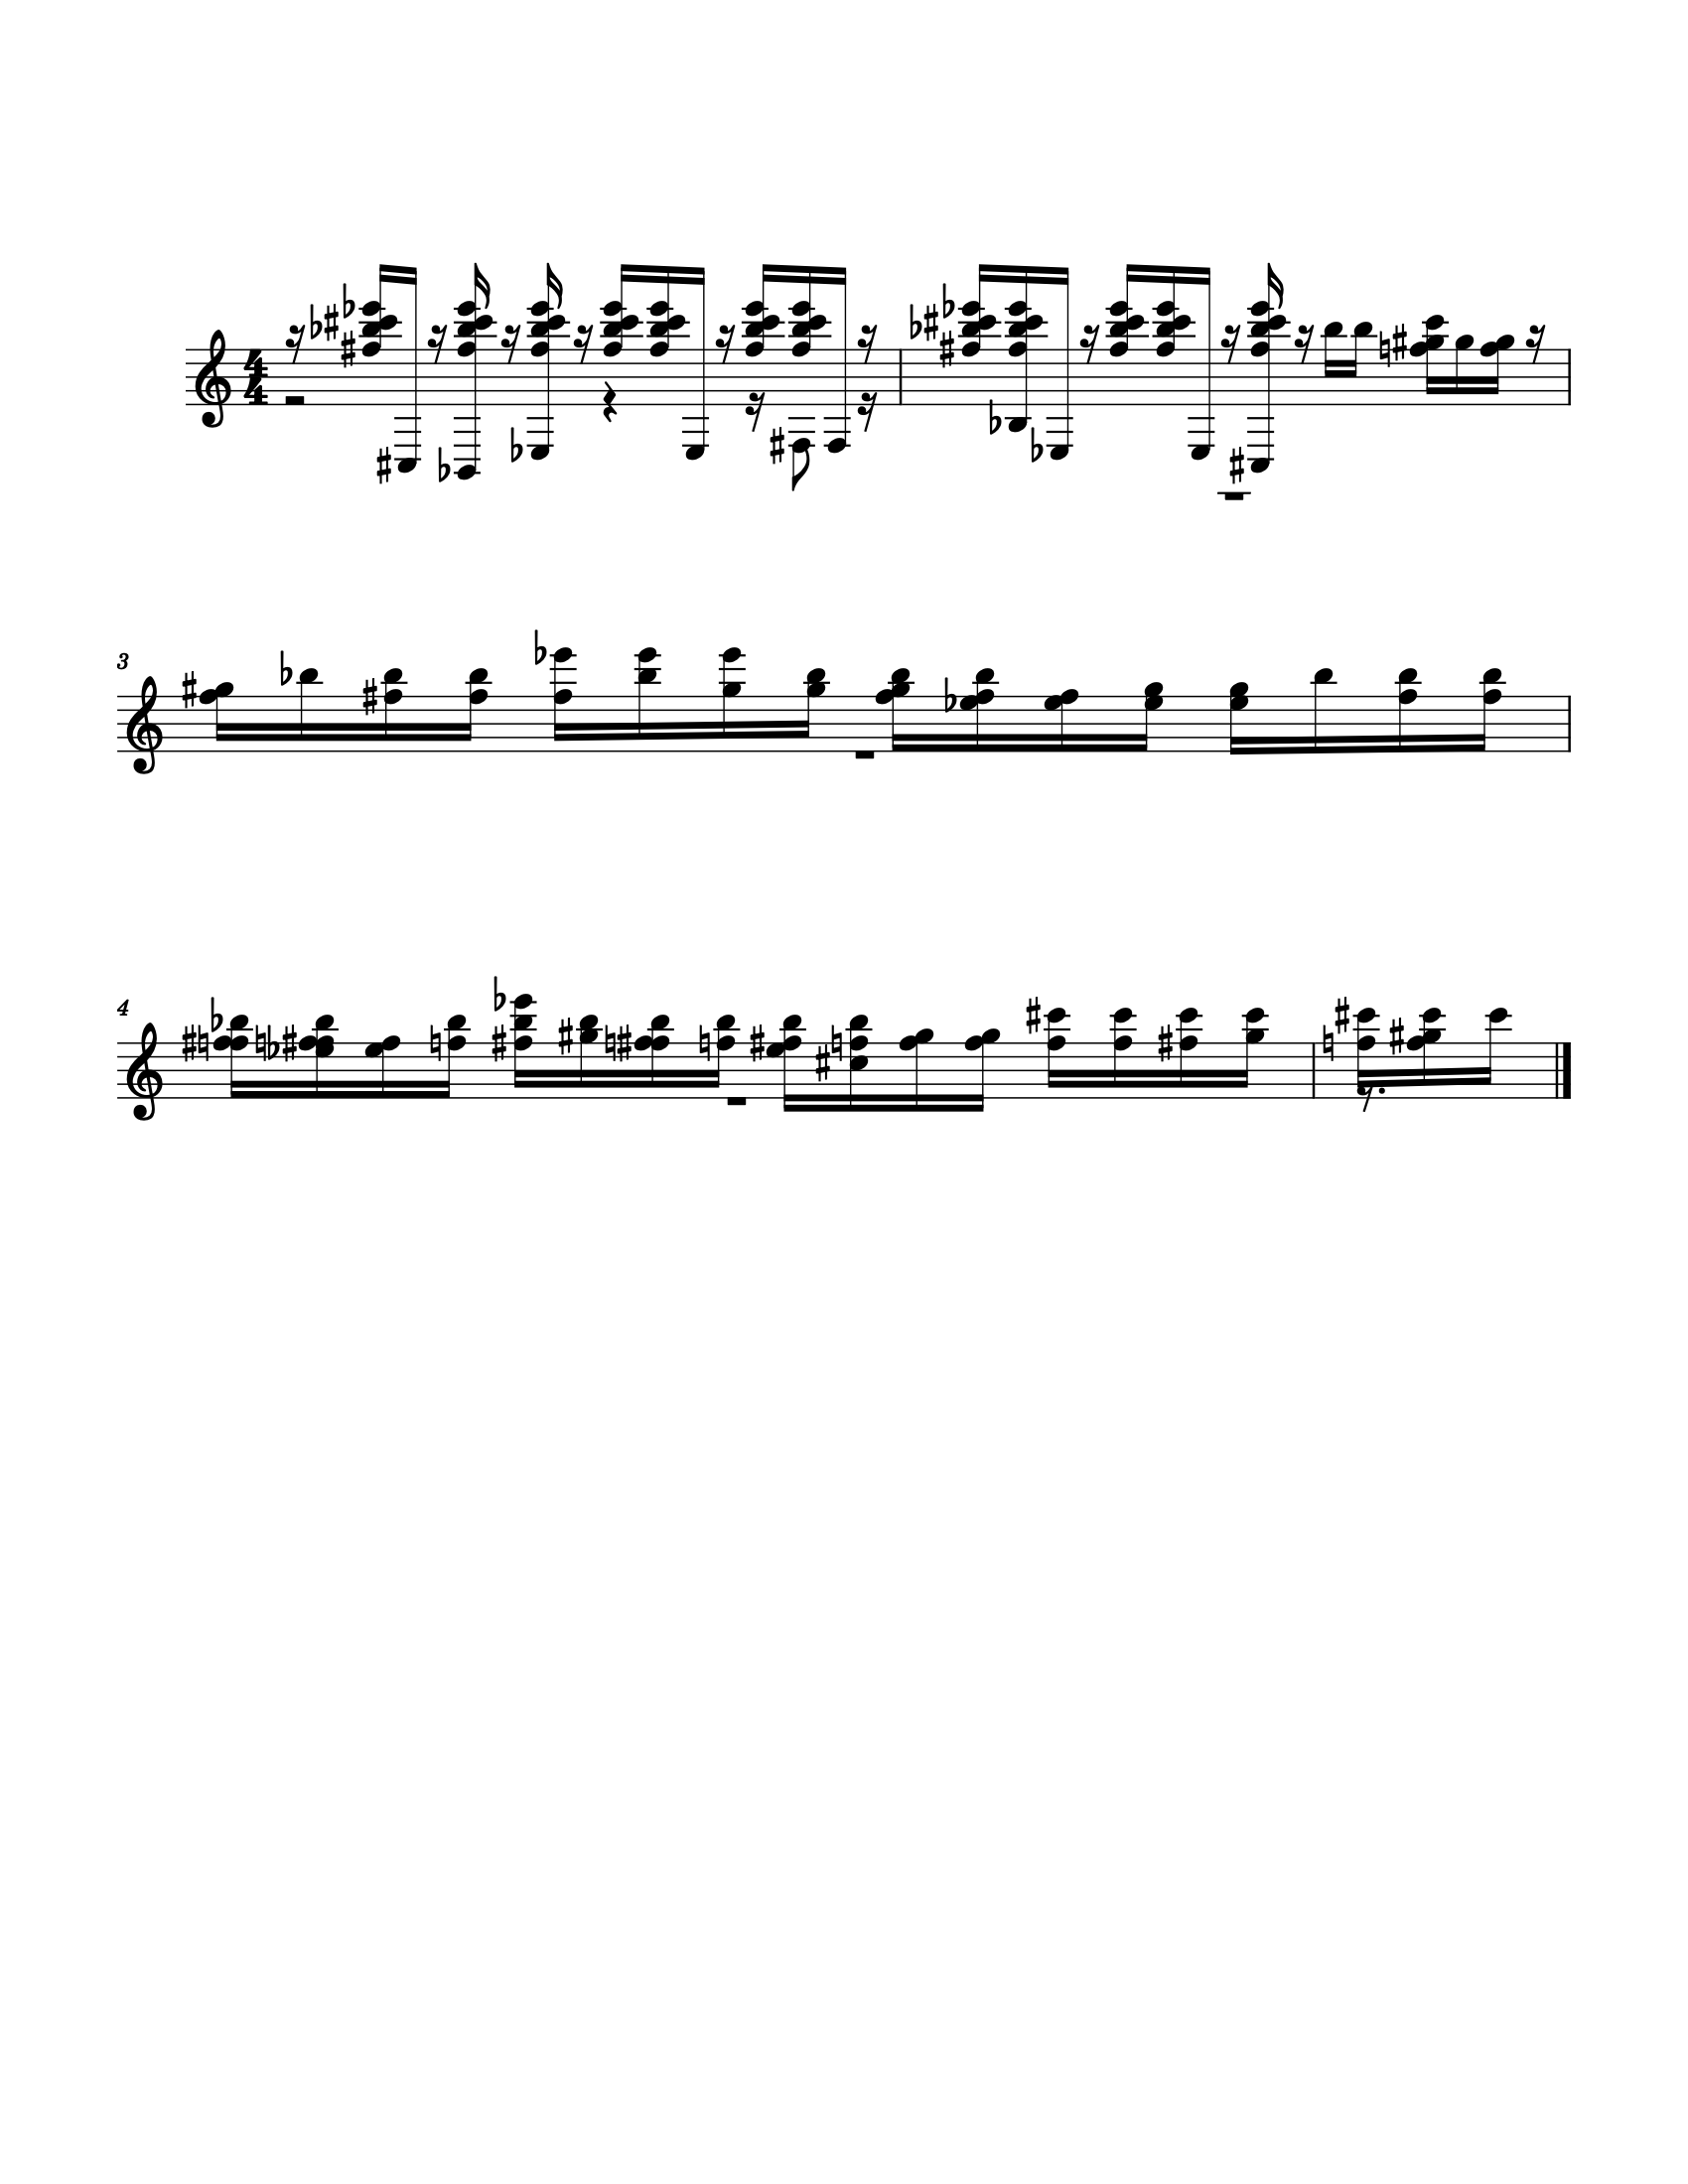

In [20]:
pred.show()

### Pop Music Theory

According to hooktheory, the most popular chord progression is I-V-vi-IV  
https://www.hooktheory.com/theorytab/common-chord-progressions

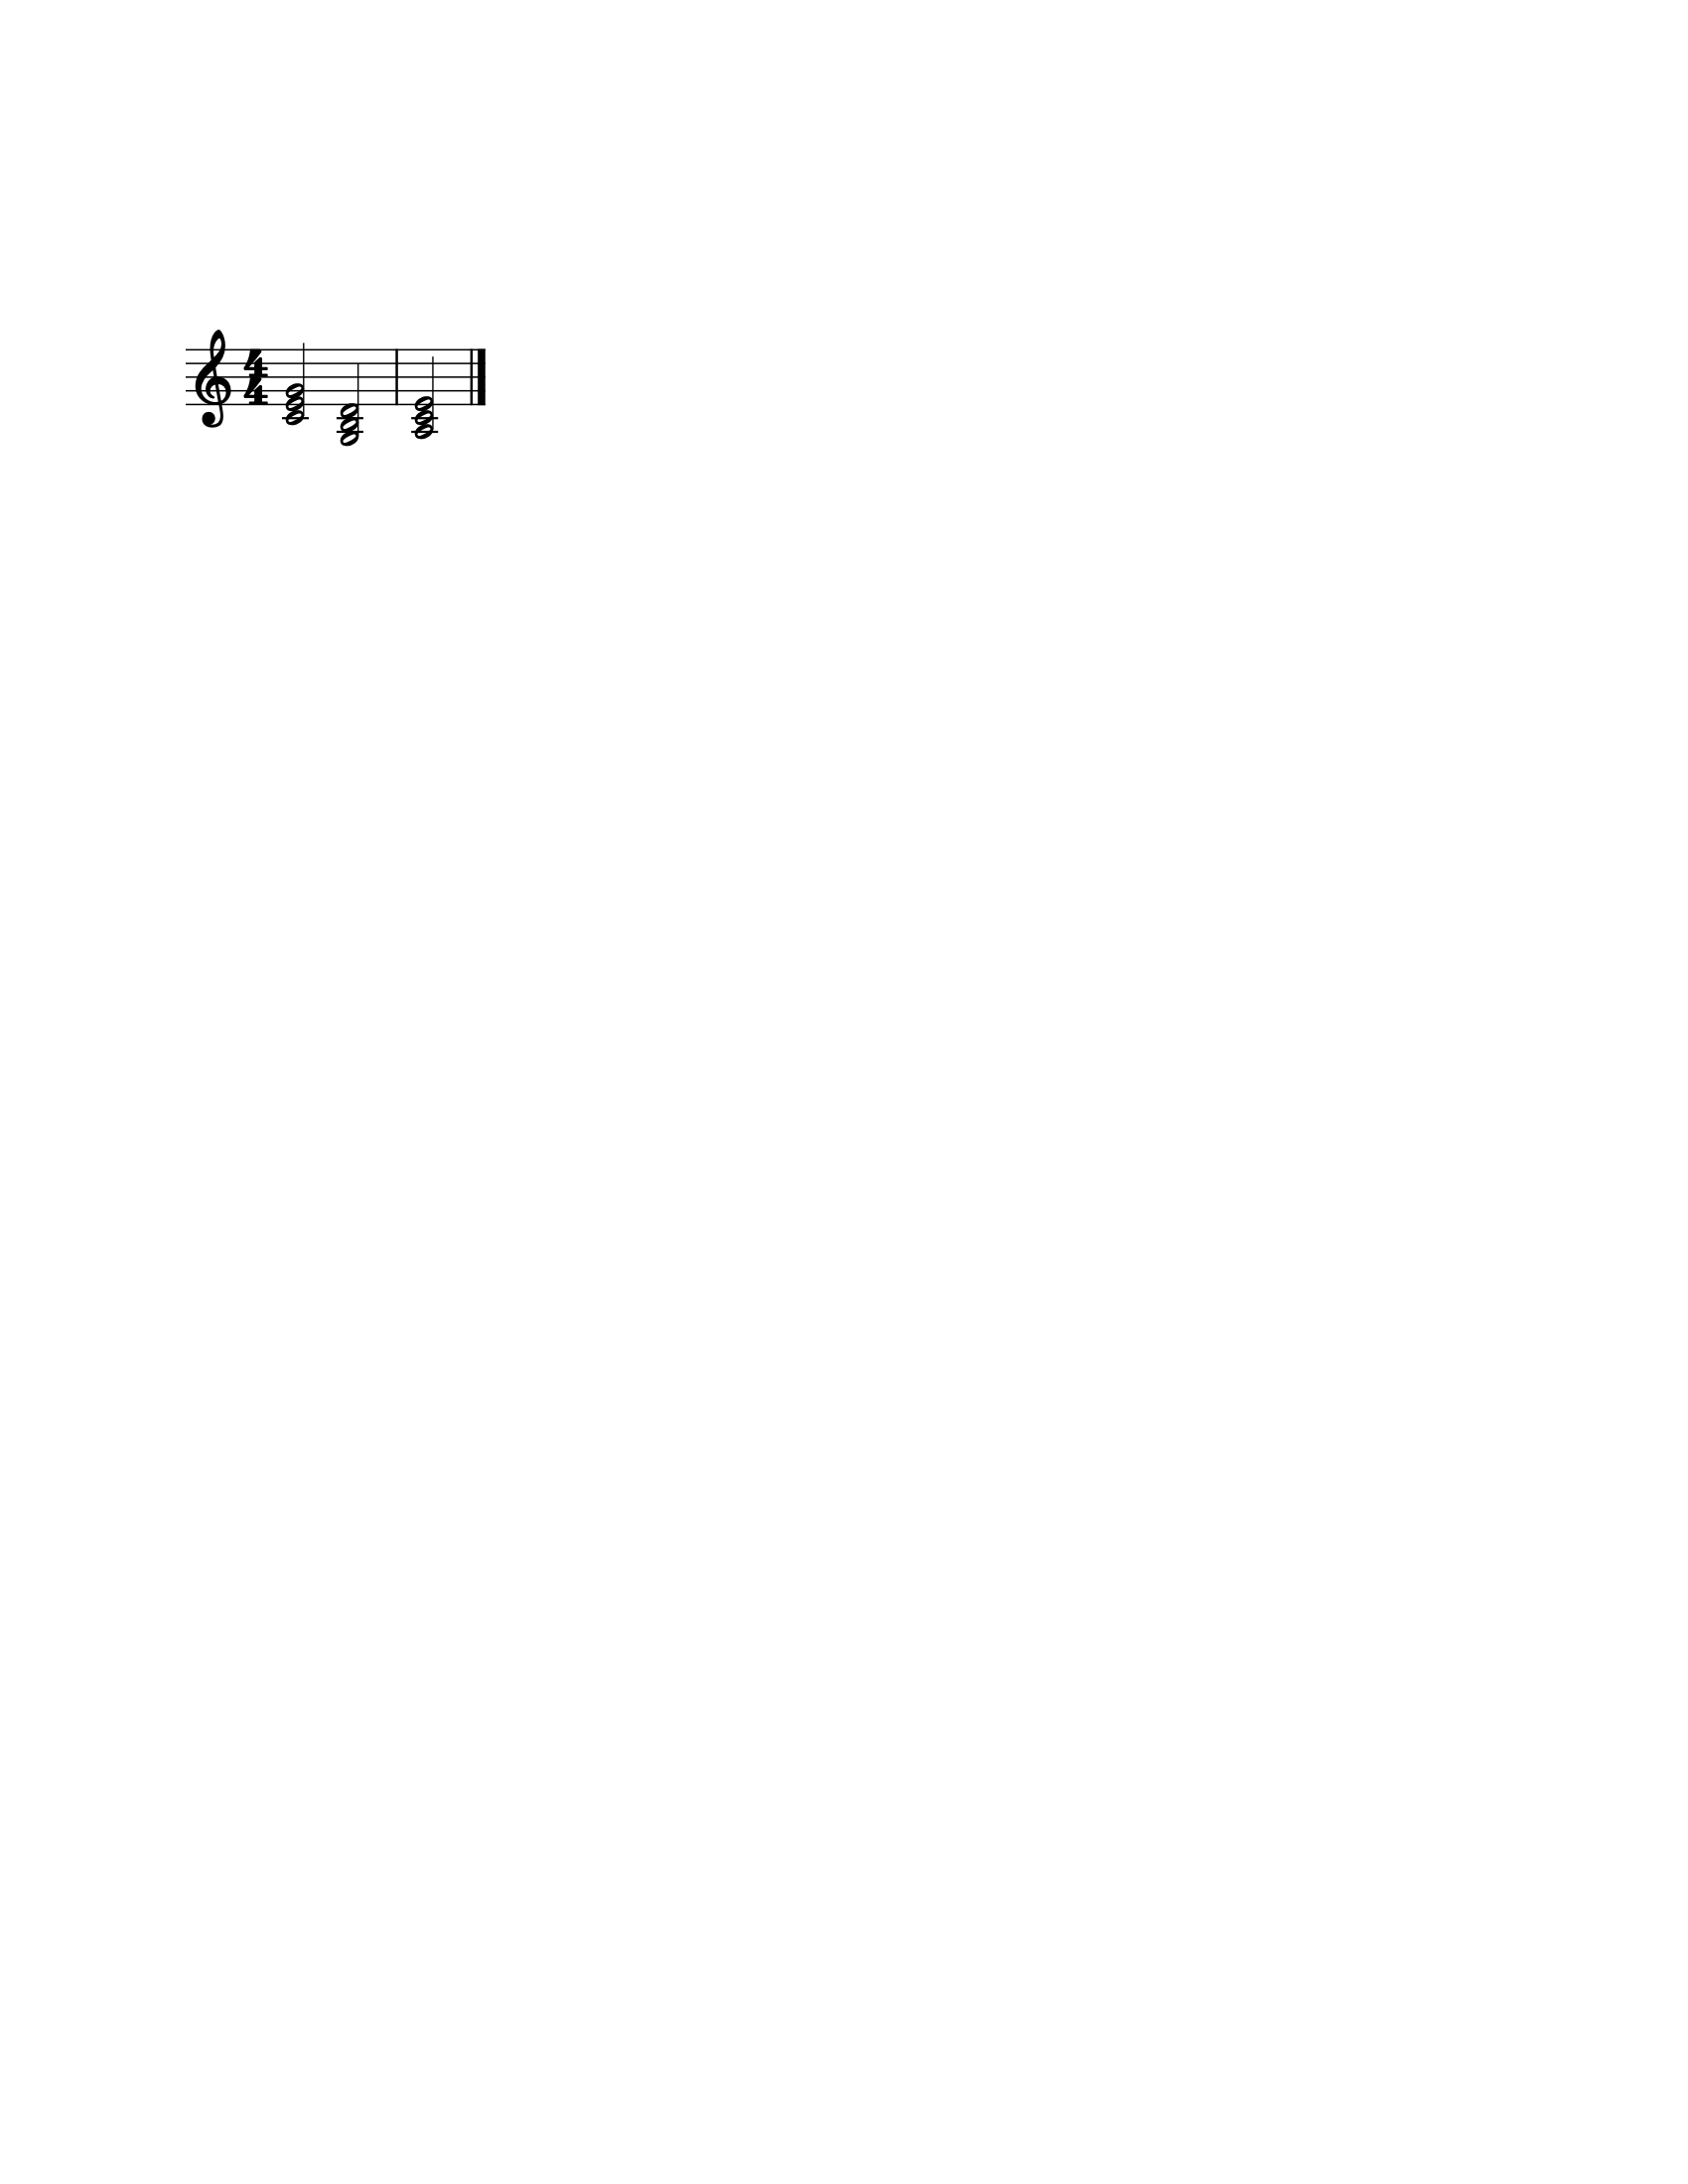

In [21]:
# Let's create a partial progression I-V-vi
p = music21.stream.Part()
p.append(music21.chord.Chord('C4 E4 G4', type='half')) # I
p.append(music21.chord.Chord('G3 B3 D4', type='half')) # V
p.append(music21.chord.Chord('A3 C4 E4', type='half')) # vi
s = music21.stream.Score([p])
chord_item = MusicItem.from_stream(s, vocab)
chord_item.show()

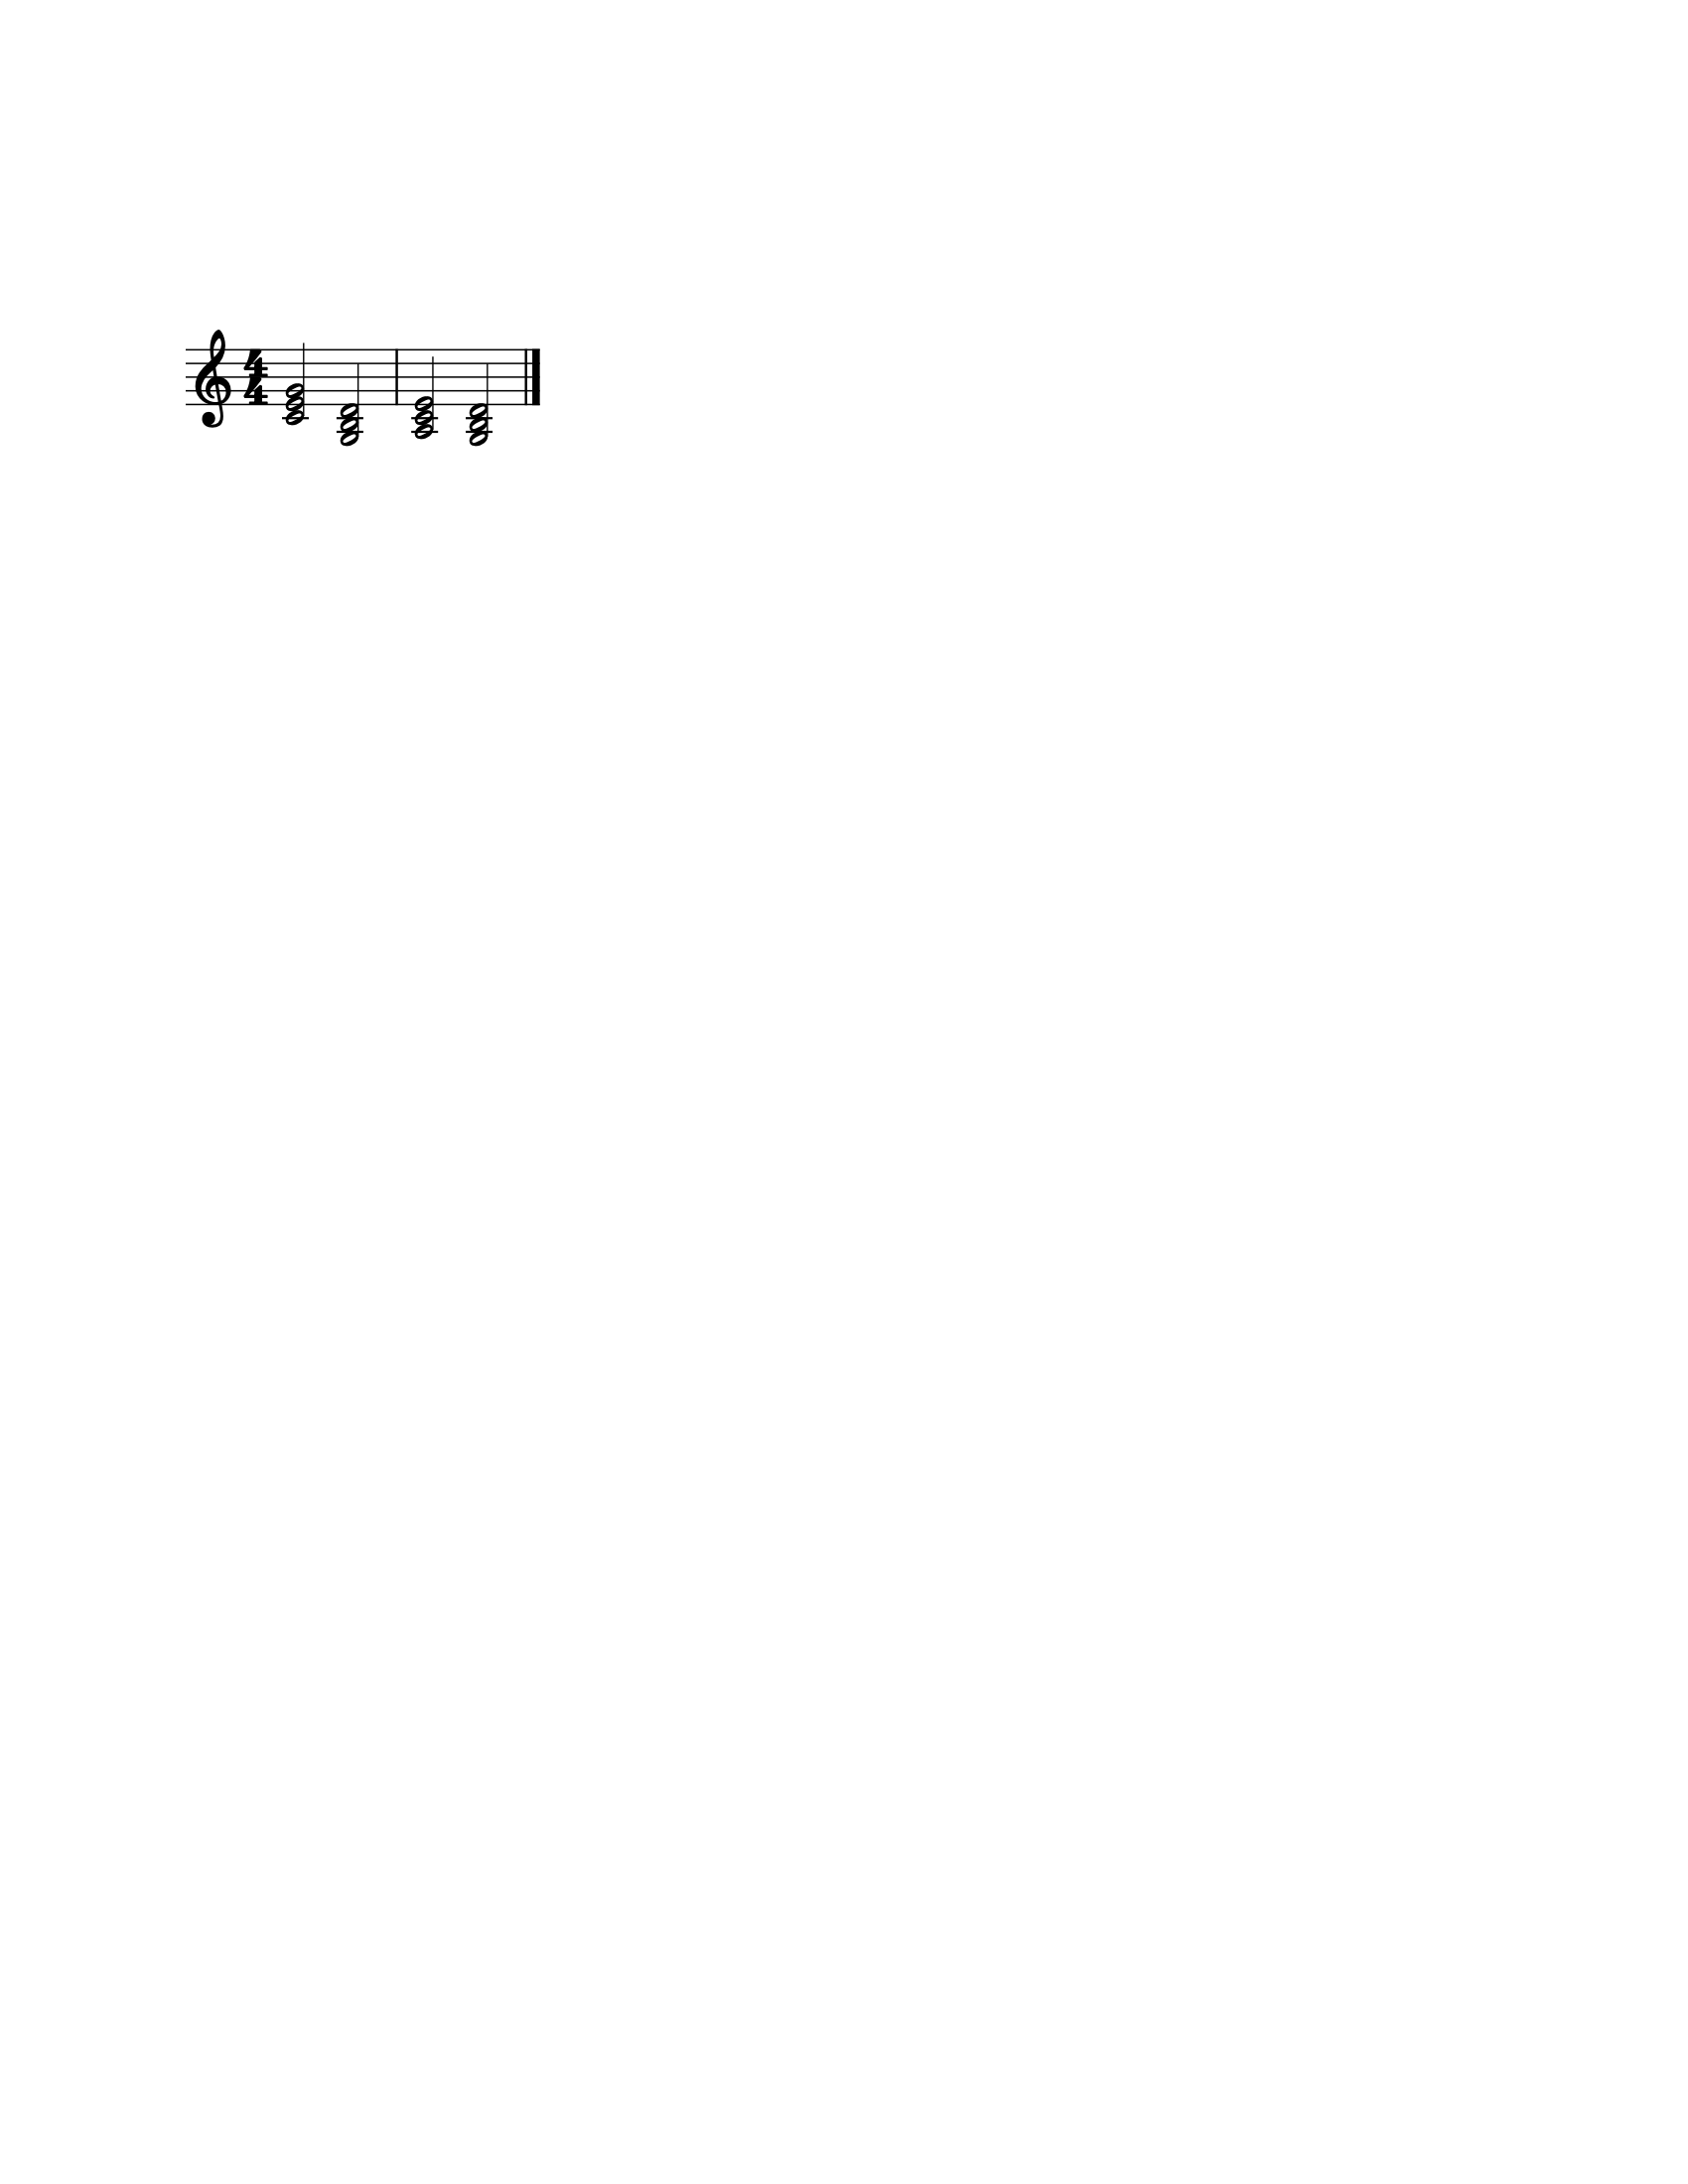

In [22]:
temperaturs = (0.5,0.5) # Let's lower the note randomness for this test
pred, full = learn.predict(chord_item, n_words=10, temperatures=(0.5,0.5))
full.show()

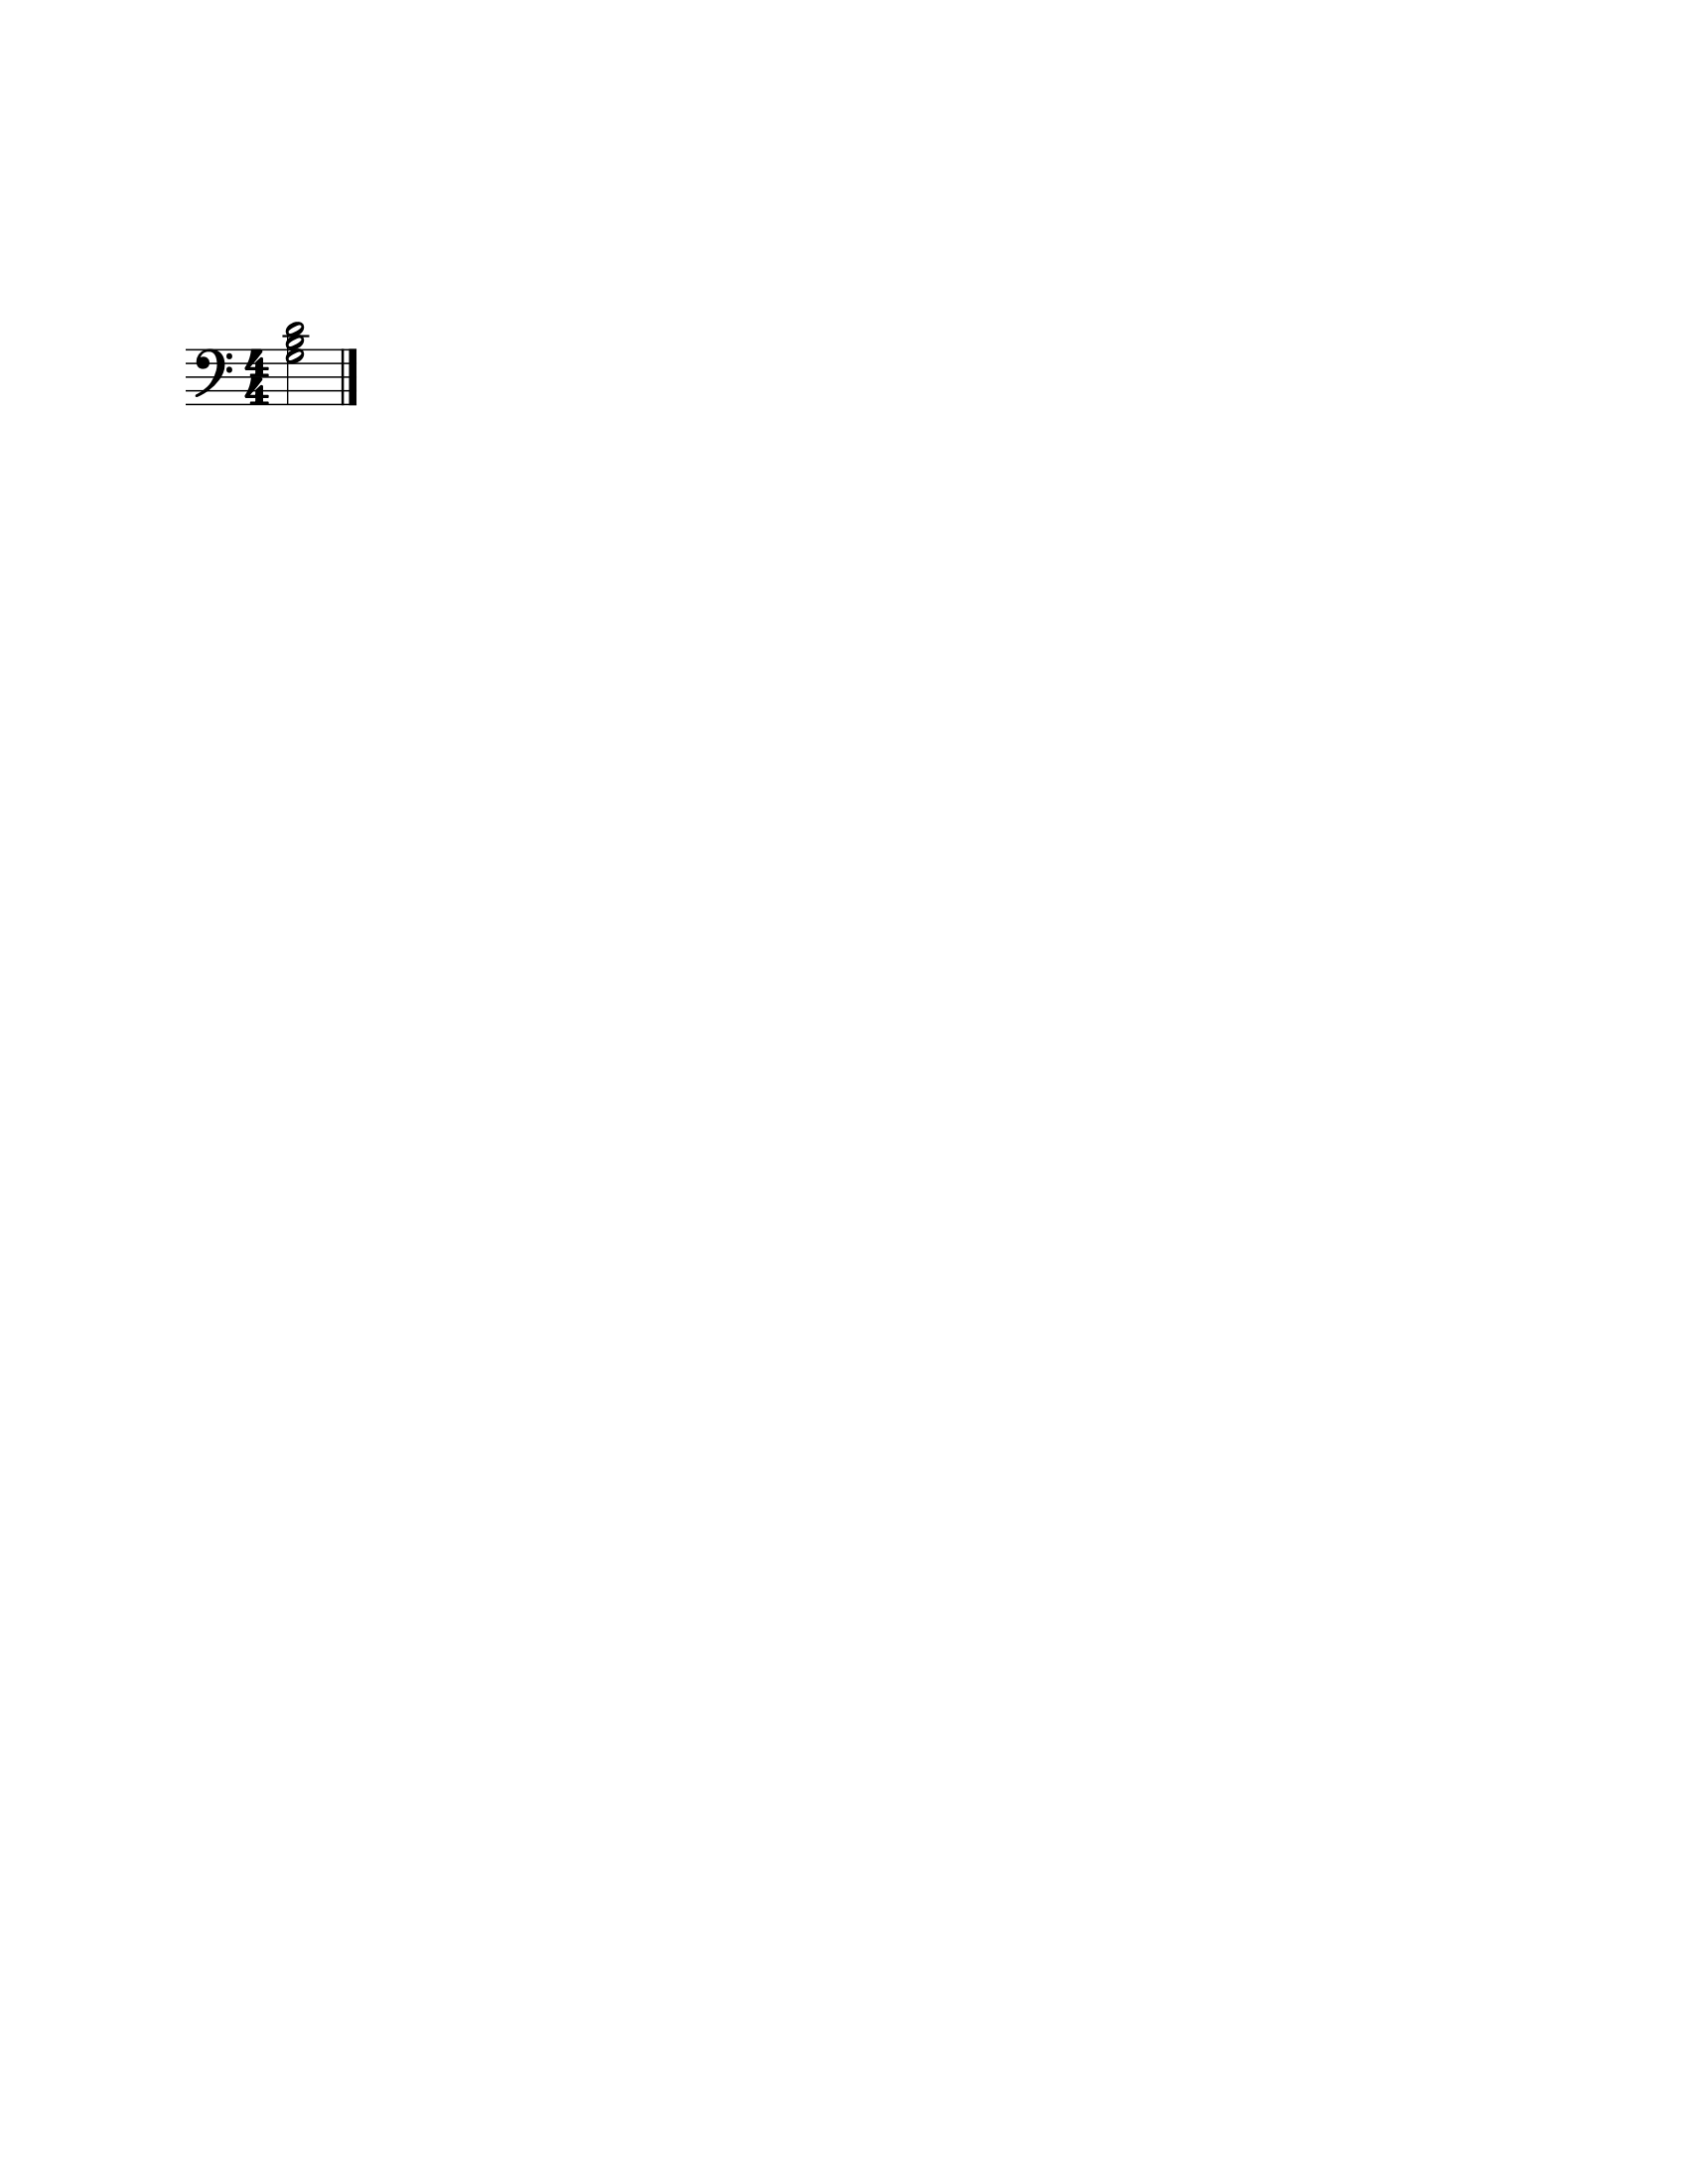

In [23]:
# Predicted chords - IV
pred.show()

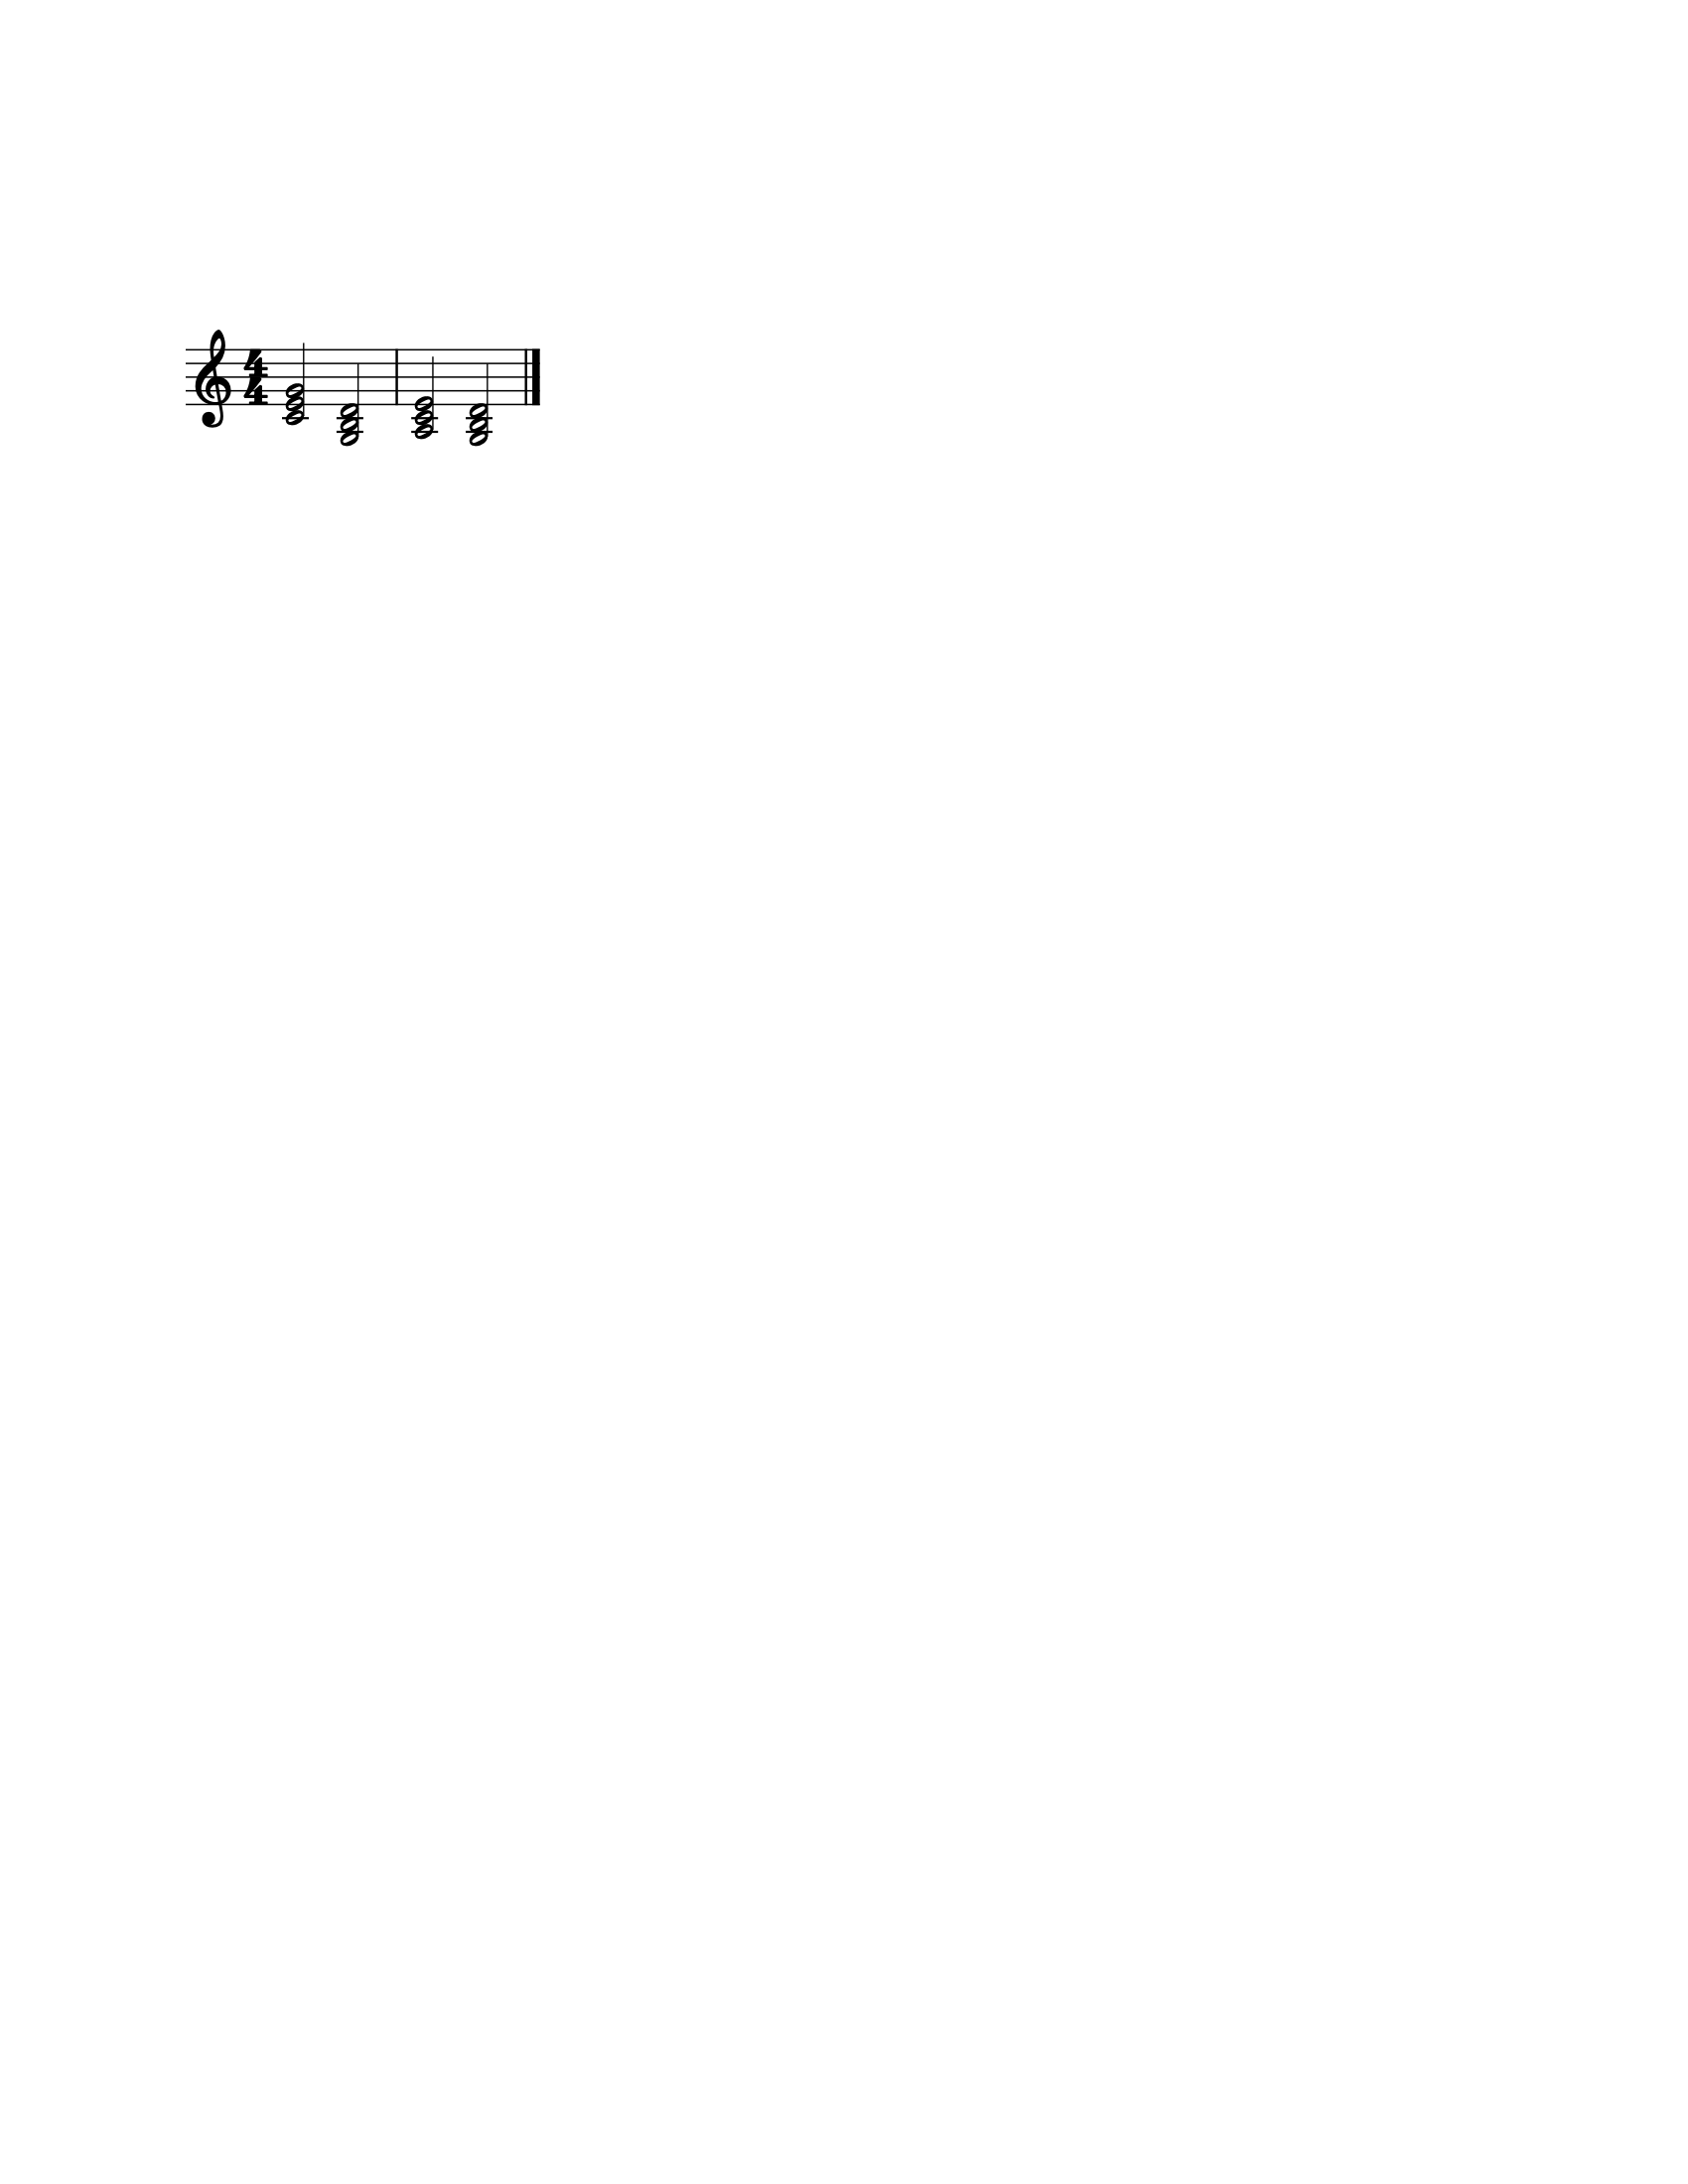

In [24]:
# Full sequence
chord_item.append(pred).show()

Looks like it predicted the most popular progression!

#### Predict without a starting sequence

In [25]:
empty_item = MusicItem.empty(vocab)

In [26]:
pred, full = learn.predict(empty_item, n_words=200)

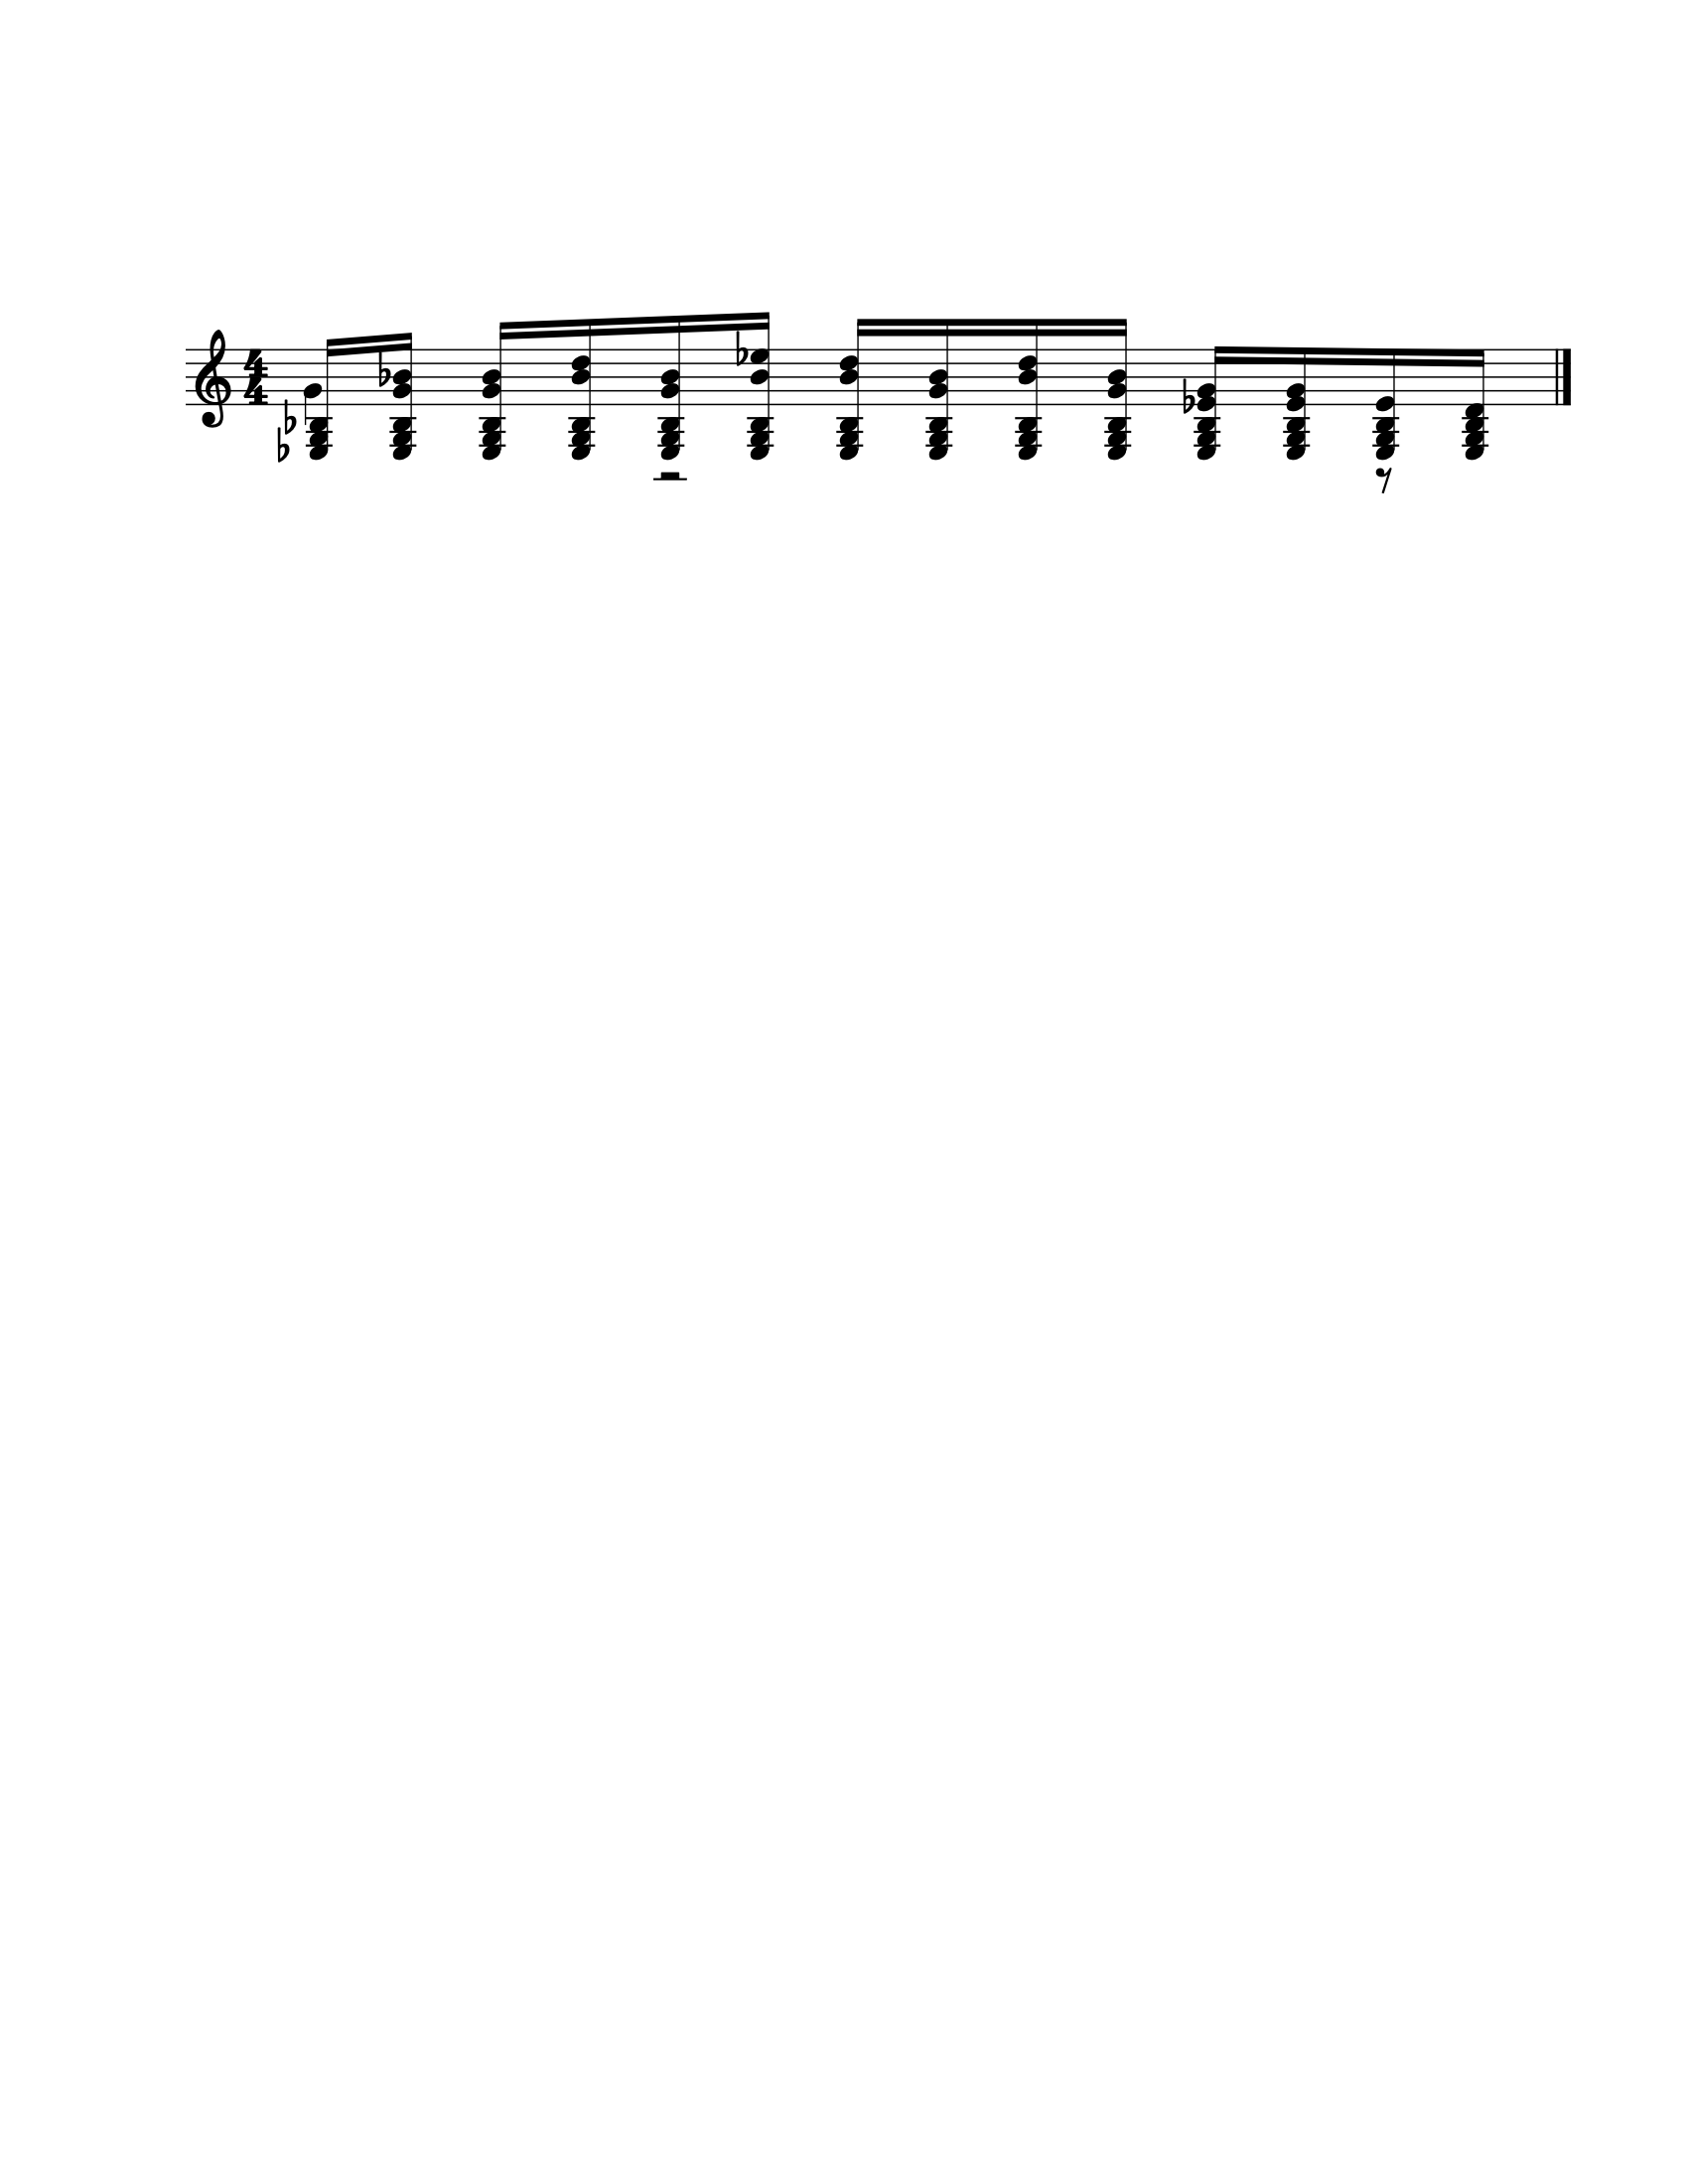

In [27]:
pred.show()

In [28]:
pred.play()